---
layout: post
title: "시계열 데이터 - LSTM"
author: "Chanjun Kim"
categories: Data분석
tags: [Data, TimeSeries, ARIMA, LSTM, BOOSTING, REGRESSION, 시계열데이터, 시계열분석]
image: 06_LSTM.png
---

## **학습목적**
이 포스팅에선 시계열 데이터를 다루는 딥러닝 기술인 LSTM을 활용하여 예측을 해보겠습니다.<br>
데이터를 쉽게 만들기 위하여 제공되는 TimeseriesGenerator를 활용하여 데이터셋을 구축을 해보겠습니다.<br>
> - 이 글은 LSTM을 활용하고 다양하게 모델 및 파라미터를 바꾸는 것에 집중되어 있습니다. (LSTM의 원리 등은 나중에 따로 포스팅하도록 하겠습니다.) <br>
> - 또한 데이터 EDA에 대한 글은 따로 포스팅하겠습니다.

In [1]:
import os
import sys
import warnings
from tqdm import tqdm

import itertools
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

import scipy
import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, RNN, Reshape
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
mpl.rcParams['axes.unicode_minus'] = False
# fm._rebuild()
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["figure.figsize"] = (10,10)

#### - 데이터는 기존 ARIMA 포스팅과 같습니다.

In [4]:
train = pd.read_csv("data/dacon/energy/train.csv", encoding = "cp949")
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [5]:
test = pd.read_csv("data/dacon/energy/test.csv", encoding = "cp949")
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y_col = "전력사용량(kWh)"

- Traing set에 대하여 MinMax Scaling을 시켜주고, validation set에도 적용시켜주기 위한 함수

In [7]:
def fit_minmmax_scaler(val_data, minmax_value) :
    val_data = pd.merge(val_data, minmax_value, on = "num")
    val_data[y_col]  = val_data.apply(lambda x : (x[y_col] - x["min"]) / (x["max"] - x["min"]), axis = 1)
    val_data.drop(columns = ["max", "min"], inplace = True)
    
    return val_data

- Keras의 TimeSeriesGenerator를 통하여 length를 넣으면 X값과 Y값을 학습시킬 수 있도록 만들어주는 함수.

In [8]:
def make_data(data, y_col, length, start_idx = 1) :
    for i, x in tqdm(enumerate(data.num.unique())):
        X = data.loc[data.num == x].iloc[ : , 1:].reset_index(drop = True)
        Y = data.loc[data.num == x][[y_col]].reset_index(drop = True)
        X = np.array(X)
        Y = np.array(Y)
        data_gen = TimeseriesGenerator(X, Y, length=length, batch_size = len(X) - length)

        if i == 0 :
            Xs = data_gen[0][0]
            Ys = data_gen[0][1]
        else :
            Xs = np.concatenate((Xs, data_gen[0][0]))
            Ys = np.concatenate((Ys, data_gen[0][1]))

    return Xs, Ys        

In [9]:
def history_plot(history) :
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['mse'], 'b', label='train mse')
    acc_ax.plot(history.history['val_mse'], 'g', label='val mse')
    acc_ax.set_ylabel('mse')
    acc_ax.legend(loc='upper right')

    plt.show()

In [10]:
def return_predict(train, test, date_idx, length) :
    result = np.zeros(len(val))
    result_idx = 0

    for i in tqdm(test.num.unique()):
        onehot_value = train.loc[train.num == i].iloc[-1: , 1:-1]
        for n, m in enumerate(range(len(val[val.num == i]))) :
            if n == 0 :
                predict_data = np.array(train.loc[train.num == i].iloc[-24: , 1:])
            else : 
                predict_data = predict_data[-24:]
            next_= model.predict(np.reshape(predict_data, (1, length, predict_data.shape[1])))
            predict_data = np.concatenate([predict_data, np.array([list(onehot_value.values[0]) + [next_[0][0]]])])
            result[result_idx] = next_
            result_idx += 1
    
    ret = date_idx[["num", "date_time"]]
    ret["predict"] = result
    ret.reset_index(drop = True, inplace = True)
    return ret

In [11]:
def predict_grp_idx(df, idx, y_col) :
    g = (
        p9.ggplot() +
        p9.geom_line(data = df[df.num == idx].assign(num = lambda x : x.num.astype(str)), 
                     mapping = p9.aes(x = "date_time", y = y_col), group = 1, color = "green", alpha = 0.6) +
        p9.geom_line(data = df[df.num == idx].assign(num = lambda x : x.num.astype(str)), 
                     mapping = p9.aes(x = "date_time", y = "predict", ), group = 1, color = "red", alpha = 0.6) +
        p9.theme_bw() +
        p9.theme(text = p9.element_text(family = "NanumMyeongjo"))
    )
    return g

In [12]:
def metric_plot(grp_val) :
    g = (
        p9.ggplot() +
        p9.geom_col(data = pd.DataFrame(grp_val.groupby("num").apply(lambda x : mean_absolute_error(x.predict, x[y_col]))).reset_index().rename(columns = {0 : "MAE"}), 
                 mapping = p9.aes(x = "num", y = "MAE", fill = "num"), color = "white") +
        p9.theme_bw() +
        p9.theme(text = p9.element_text(family = "NanumMyeongjo"))
    )
    return g

- 다양한 모델의 검증을 위하여 train과 val을 나눈다. 기준의 이유는 딱히 없다.

In [13]:
val = train[train.date_time >= "2020-08-15"]
train = train[train.date_time < "2020-08-15"]

In [14]:
oh_encoder = OneHotEncoder()

#### **LSTM 모델의 구성 및 EPOCH, LOSS FUNCTION 등을 바꿔가며 정확도에 어떤 영향을 미치는 지 알아보도록 하겠습니다.**

---

### **모델 공통부분**
- CALL_BACK : Early Stopping, Validation loss가 가장 낮은 모델 저장
- DROP OUT : 0.2
- BATCH SIZE : 128
<br>

### **첫번째 모델**
- LOSS FUNCTION : MAE
- EPOCH : 30
- LSTM LAYER : 1
- LSTM UNIT : 32

In [15]:
tf_train = pd.concat([
    train["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.fit_transform(train[["num"]]).toarray()).add_prefix("num"), 
    train[[y_col]].reset_index(drop = True)], 
    axis = 1)

In [16]:
tf_val = pd.concat([
    val["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.transform(val[["num"]]).toarray()).add_prefix("num"), 
    val[y_col].reset_index(drop = True)], 
    axis = 1)

In [17]:
minmax_value = tf_train.groupby("num").agg({y_col : [max, min]}).reset_index().droplevel(axis = 1, level = 0)
minmax_value.columns = ["num", "max", "min"]

In [18]:
tf_train[y_col] = tf_train.groupby("num").apply(lambda x : (x[y_col]-min(x[y_col]))/(max(x[y_col])-min(x[y_col]))).values

In [19]:
tf_val = fit_minmmax_scaler(tf_val, minmax_value)

In [20]:
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="h5/lstm_model.h5", monitor='val_loss', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [21]:
trainX, trainY = make_data(data = tf_train, y_col = y_col, length = 24)

60it [00:12,  4.78it/s]


In [22]:
valX, valY = make_data(data = tf_val, y_col = y_col, length = 24)

60it [00:01, 37.49it/s]


In [23]:
print(trainX.shape)
print(trainY.shape)

(106560, 24, 61)
(106560, 1)


In [24]:
print(valX.shape)
print(valY.shape)

(12960, 24, 61)
(12960, 1)


In [25]:
lstm_units=32
dropout=0.2
EPOCH=30
BATCH_SIZE=128

In [26]:
model=Sequential([
    LSTM(lstm_units, return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [27]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

In [28]:
%%time
history = model.fit(trainX, trainY, validation_data = (valX, valY), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
                    callbacks=[early_stop, save_best_only])

Epoch 1/30
833/833 [==============================] - 16s 16ms/step - loss: 0.0974 - mse: 0.0236 - val_loss: 0.0529 - val_mse: 0.0071985 - mse:
Epoch 2/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0491 - mse: 0.0057 - val_loss: 0.0456 - val_mse: 0.0058
Epoch 3/30
833/833 [==============================] - 14s 17ms/step - loss: 0.0429 - mse: 0.0048 - val_loss: 0.0436 - val_mse: 0.0054
Epoch 4/30
833/833 [==============================] - 14s 16ms/step - loss: 0.0401 - mse: 0.0043 - val_loss: 0.0433 - val_mse: 0.0055
Epoch 5/30
833/833 [==============================] - 14s 17ms/step - loss: 0.0384 - mse: 0.0040 - val_loss: 0.0435 - val_mse: 0.0051
Epoch 6/30
833/833 [==============================] - 14s 16ms/step - loss: 0.0371 - mse: 0.0038 - val_loss: 0.0411 - val_mse: 0.0047:
Epoch 7/30
833/833 [==============================] - 14s 16ms/step - loss: 0.0363 - mse: 0.0037 - val_loss: 0.0406 - val_mse: 0.0046
Epoch 8/30
833/833 [==============================]

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                12032     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________


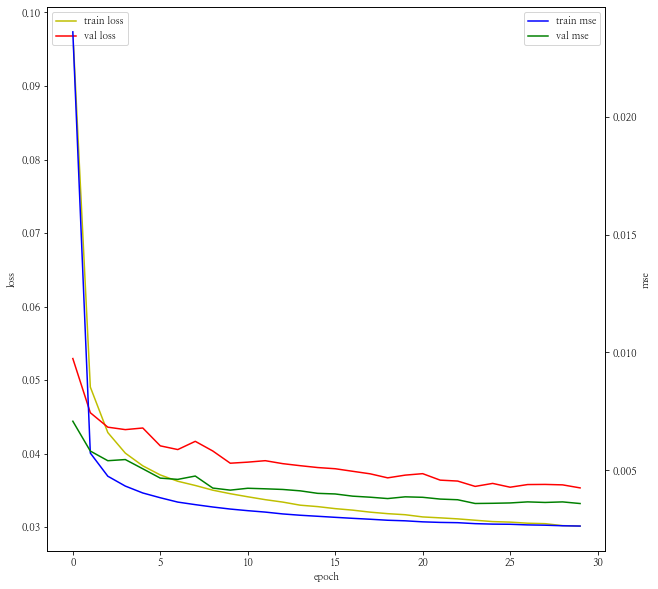

In [30]:
history_plot(history)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_37_0.png)

In [31]:
%time result = return_predict(tf_train, tf_val, val, 24)

100%|███████████████████████████████████████████████████| 60/60 [09:17<00:00,  9.29s/it]

Wall time: 9min 17s


In [32]:
grp_val = pd.concat([result, tf_val[y_col]], axis = 1)

0.17285940353905294


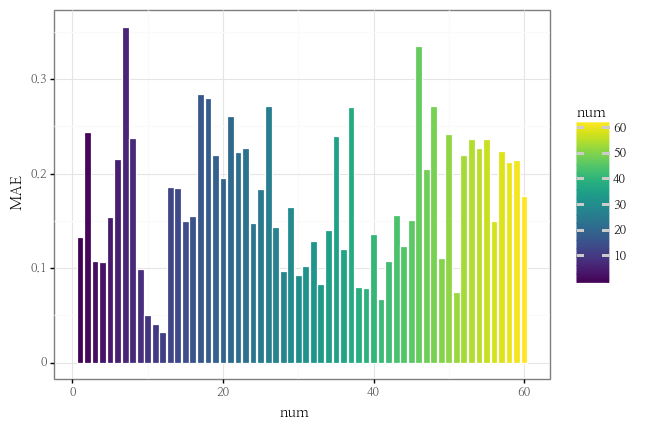

<ggplot: (124046410132)>

In [33]:
print(mean_absolute_error(grp_val.predict, grp_val[y_col]))
metric_plot(grp_val)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_40_1.png)

In [34]:
mae_min = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmin()
mae_max = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmax()
print(f"mae가 가장 낮은 건물은 {mae_min}번 건물이고 mae가 가장 높은 건물은 {mae_max}번 건물입니다.")

mae가 가장 낮은 건물은 12번 건물이고 mae가 가장 높은 건물은 7번 건물입니다.


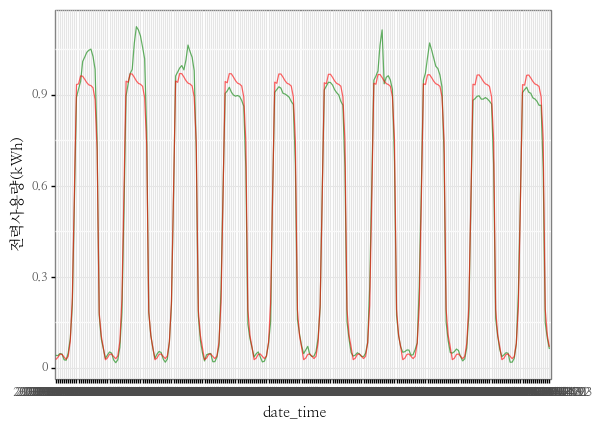

<ggplot: (124045548532)>

In [35]:
predict_grp_idx(grp_val, mae_min, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_42_0.png)

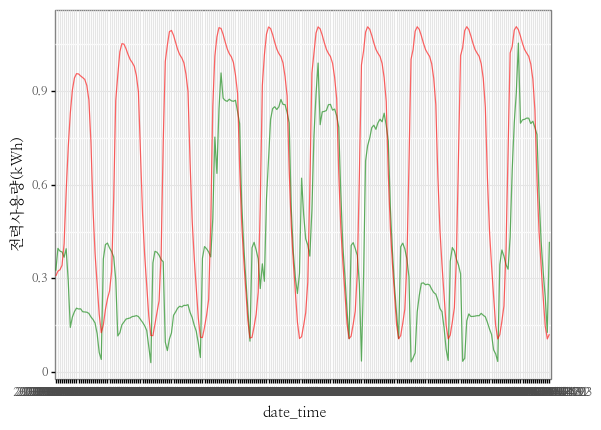

<ggplot: (124046148337)>

In [36]:
predict_grp_idx(grp_val, mae_max, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_43_0.png)

#### **첫번째 모델 평가**
- 모델의 LOSS를 봤을 때 전체적으로 수렴해가는 과정을 볼 수 있습니다.
- MAE가 가장 낮은 12번 건물의 경우 꽤 정교하게 맞춘 듯 보이나, 7번 건물은 계절성 정도만 맞춘 것처럼 보입니다. 
    - 12번 건물의 경우도 패턴이 거의 일정한 모습을 보이는 건물로, 아직까지는 복잡한 모형에 대하여 제대로 피팅이 되지 않았다는 판단이 듭니다.

---

### **두번째 모델**
- LOSS FUNCTION : MSE
- EPOCH : 30
- LSTM LAYER : 1
- LSTM UNIT : 32

In [37]:
model=Sequential([
    LSTM(lstm_units, return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [38]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [39]:
%%time
history = model.fit(trainX, trainY, validation_data = (valX, valY), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
                    callbacks=[early_stop, save_best_only])

Epoch 1/30
833/833 [==============================] - 16s 16ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 3/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 6/30
833/833 [==============================] - 14s 16ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/30
833/833 [==============================] - 13s 16ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/30
833/833 [==============================] - 13s 16ms

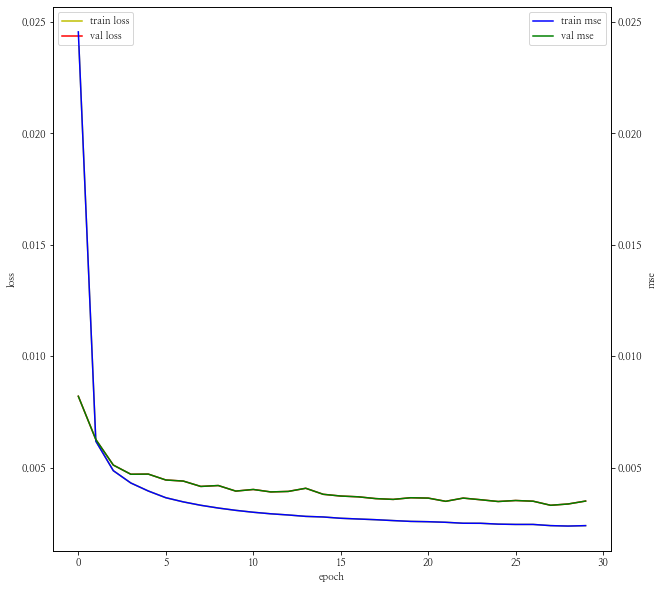

In [40]:
history_plot(history)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_49_0.png)

In [41]:
%time result = return_predict(tf_train, tf_val, val, 24)

100%|███████████████████████████████████████████████████| 60/60 [09:40<00:00,  9.67s/it]

Wall time: 9min 40s


In [42]:
grp_val = pd.concat([result, tf_val[y_col]], axis = 1)

0.2174252761180616


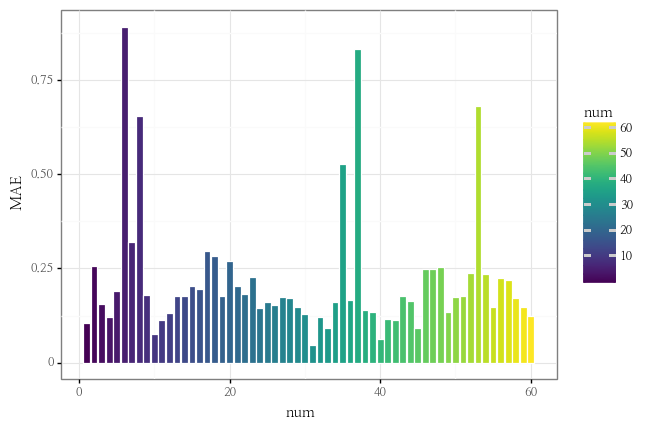

<ggplot: (124046271639)>

In [43]:
print(mean_absolute_error(grp_val.predict, grp_val[y_col]))
metric_plot(grp_val)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_52_1.png)

In [44]:
mae_min = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmin()
mae_max = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmax()
print(f"mae가 가장 낮은 건물은 {mae_min}번 건물이고 mae가 가장 높은 건물은 {mae_max}번 건물입니다.")

mae가 가장 낮은 건물은 31번 건물이고 mae가 가장 높은 건물은 6번 건물입니다.


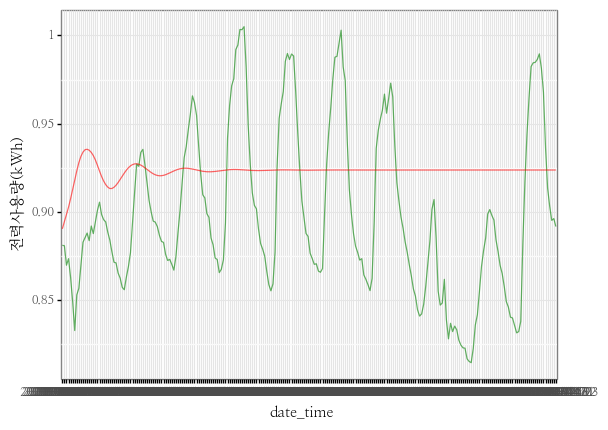

<ggplot: (124028755234)>

In [45]:
predict_grp_idx(grp_val, mae_min, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_54_0.png)

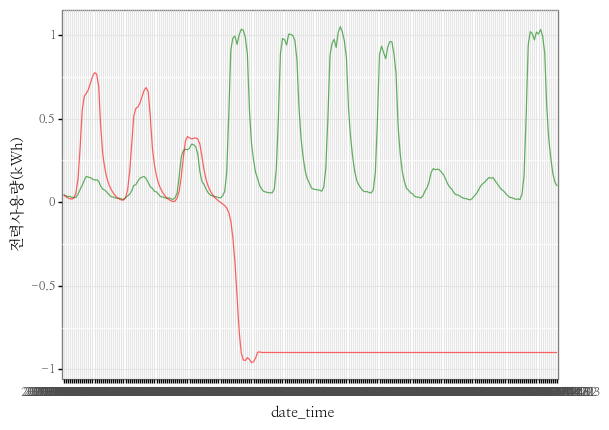

<ggplot: (124046655166)>

In [46]:
predict_grp_idx(grp_val, mae_max, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_55_0.png)

#### **두번째 모델 평가**
- 역시 LOSS 부분을 봤을 때 수렴하는 단계에 있는 것 같습니다만, 아래의 두 건물의 그래프 모두 어디론가 값이 수렴해버리는 현상이 나타났습니다.
    - EPOCH를 좀 더 늘려 학습시키는 것을 고려해야겠습니다.
- 또한 첫번째 모델에 비해서 MAE가 높게 나왔습니다. LOSS FUNCTION이 MSE로 바꾸다보니 상대적으로 MAE가 높게 나온 것인지, 그냥 모델 fitting이 덜 된 것인지 확인이 불가능합니다..ㅜㅜ 다음엔 이런것도 고려해서 모델링을 실시해야겠습니다.

---

### **세번째 모델**
- LOSS FUNCTION : MSE
- EPOCH : 100
- LSTM LAYER : 1
- LSTM UNIT : 32

In [47]:
EPOCH=100

In [48]:
model=Sequential([
    LSTM(lstm_units, return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [49]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [50]:
%%time
history = model.fit(trainX, trainY, validation_data = (valX, valY), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
                    callbacks=[early_stop, save_best_only])

Epoch 1/100
833/833 [==============================] - 16s 17ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/100
833/833 [==============================] - 14s 16ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/100
833/833 [==============================] - 14s 16ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/100
833/833 [==============================] - 14s 16ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/100
833/833 [==============================] - 14s 17ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/100
833/833 [==============================] - 14s 17ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/100
833/833 [==============================] - 14s 17ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/100
833/833 [==============================] - 

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                12032     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________


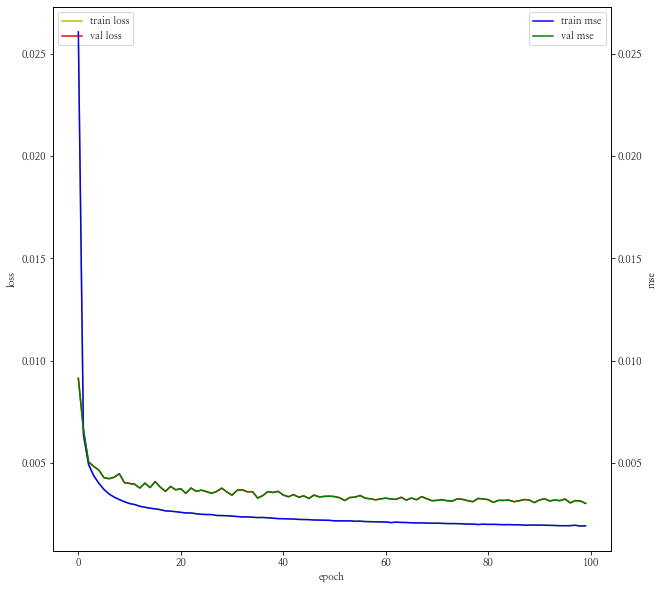

In [52]:
history_plot(history)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_63_0.png)

In [53]:
%time result = return_predict(tf_train, tf_val, val, 24)

100%|███████████████████████████████████████████████████| 60/60 [08:48<00:00,  8.81s/it]

Wall time: 8min 48s


In [54]:
grp_val = pd.concat([result, tf_val[y_col]], axis = 1)

0.1945719474061676


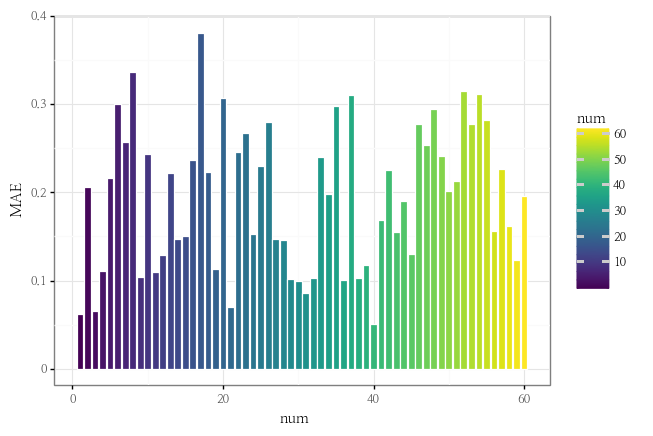

<ggplot: (124029003331)>

In [55]:
print(mean_absolute_error(grp_val.predict, grp_val[y_col]))
metric_plot(grp_val)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_66_1.png)

In [56]:
mae_min = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmin()
mae_max = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmax()
print(f"mae가 가장 낮은 건물은 {mae_min}번 건물이고 mae가 가장 높은 건물은 {mae_max}번 건물입니다.")

mae가 가장 낮은 건물은 40번 건물이고 mae가 가장 높은 건물은 17번 건물입니다.


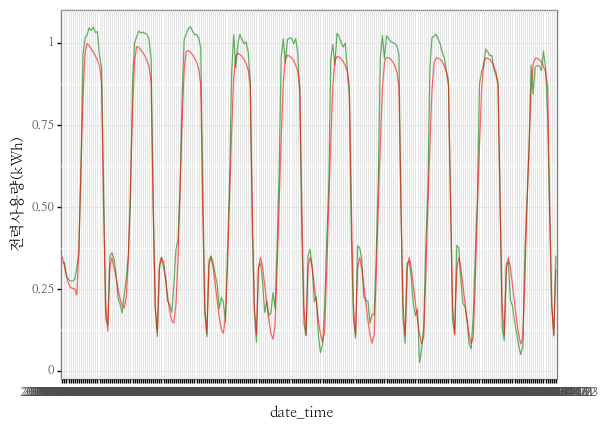

<ggplot: (124045346338)>

In [57]:
predict_grp_idx(grp_val, mae_min, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_68_0.png)

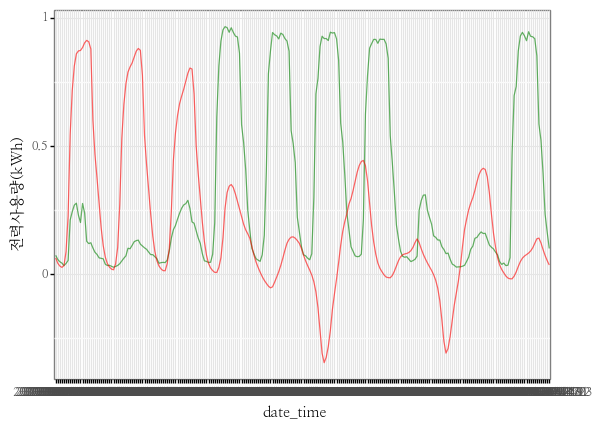

<ggplot: (124046120418)>

In [58]:
predict_grp_idx(grp_val, mae_max, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_69_0.png)

#### **세번째 모델 평가**
- MAE가 EPOCH 30일 때보다 확연히 줄어든 것을 확인할 수 있고, MAE를 LOSS FUNCTION으로 했던 모델과 거의 비슷하게 나온 것을 확인할 수 있습니다.
- 40번 건물에 대해서 조금 더 복잡한 패턴에도 잘 FITTING된 모습을 보이나, 17번 건물은 뭔가 한박자 느리다?라는 느낌이 듭니다.
- 그래프 상 거의 수렴치에서 학습이 안되는 것 같지만, Early Stopping이 있음에도 100회를 다 실시한 것으로 보아 조금 더 학습시키는 것도 나쁘지 않았을 것으로 판단됩니다.

---

### **네번째 모델**
- LOSS FUNCTION : MSE
- EPOCH : 100
- LSTM LAYER : 6
- LSTM UNIT : 64

In [59]:
EPOCH=100
lstm_units = 64

In [60]:
model=Sequential([
    LSTM(lstm_units, return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**2), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**3), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**4), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**5), return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [61]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

In [62]:
%%time
history = model.fit(trainX, trainY, validation_data = (valX, valY), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
                    callbacks=[early_stop, save_best_only])

Epoch 1/100
833/833 [==============================] - 83s 84ms/step - loss: 0.1699 - mse: 0.0605 - val_loss: 0.1064 - val_mse: 0.0340
Epoch 2/100
833/833 [==============================] - 77s 92ms/step - loss: 0.0823 - mse: 0.0210 - val_loss: 0.0997 - val_mse: 0.0320
Epoch 3/100
833/833 [==============================] - 70s 85ms/step - loss: 0.0788 - mse: 0.0205 - val_loss: 0.0963 - val_mse: 0.0308
Epoch 4/100
833/833 [==============================] - 71s 86ms/step - loss: 0.0784 - mse: 0.0205 - val_loss: 0.0978 - val_mse: 0.0310
Epoch 5/100
833/833 [==============================] - 72s 86ms/step - loss: 0.0776 - mse: 0.0204 - val_loss: 0.0956 - val_mse: 0.0316
Epoch 6/100
833/833 [==============================] - 71s 86ms/step - loss: 0.0767 - mse: 0.0203 - val_loss: 0.0979 - val_mse: 0.0315
Epoch 7/100
833/833 [==============================] - 71s 86ms/step - loss: 0.0757 - mse: 0.0201 - val_loss: 0.0955 - val_mse: 0.0319
Epoch 8/100
833/833 [==============================] - 

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 64)            32256     
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 16)            3136      
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 8)             800       
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 4)             208       
_________________________________________________________________
lstm_8 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

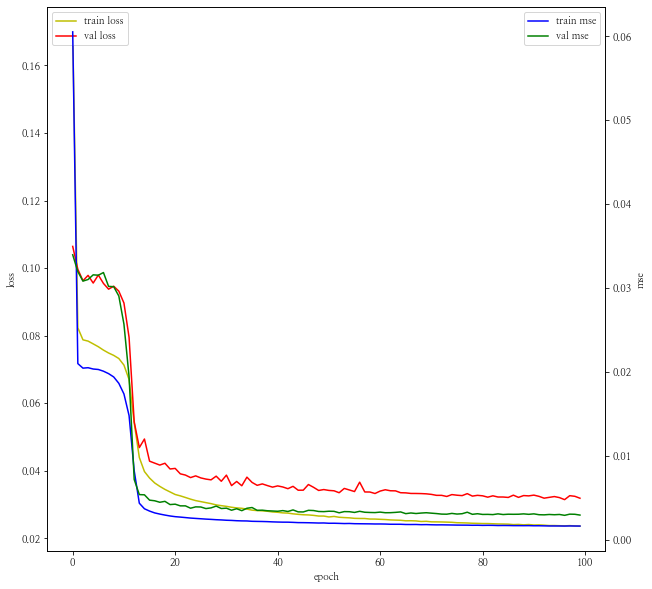

In [64]:
history_plot(history)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_77_0.png)

In [65]:
%time result = return_predict(tf_train, tf_val, val, 24)

100%|███████████████████████████████████████████████████| 60/60 [10:15<00:00, 10.26s/it]

Wall time: 10min 15s


In [66]:
grp_val = pd.concat([result, tf_val[y_col]], axis = 1)

0.16118038335659746


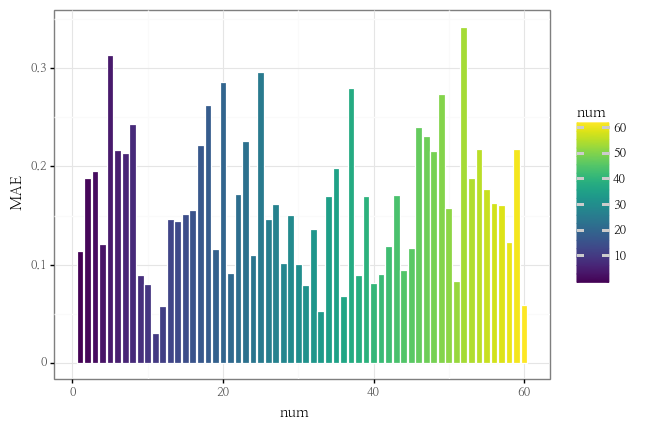

<ggplot: (124031047138)>

In [67]:
print(mean_absolute_error(grp_val.predict, grp_val[y_col]))
metric_plot(grp_val)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_80_1.png)

In [68]:
mae_min = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmin()
mae_max = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmax()
print(f"mae가 가장 낮은 건물은 {mae_min}번 건물이고 mae가 가장 높은 건물은 {mae_max}번 건물입니다.")

mae가 가장 낮은 건물은 11번 건물이고 mae가 가장 높은 건물은 52번 건물입니다.


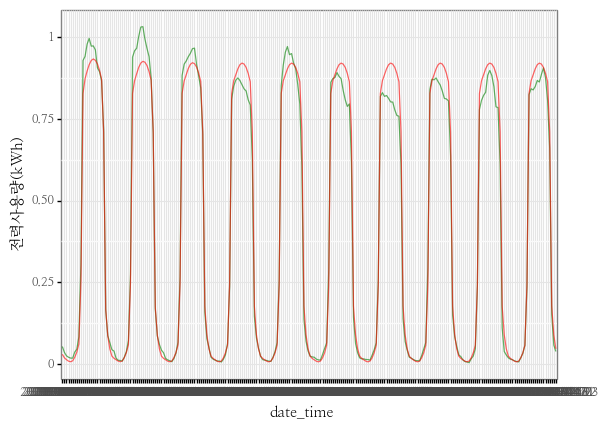

<ggplot: (124116280823)>

In [69]:
predict_grp_idx(grp_val, mae_min, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_82_0.png)

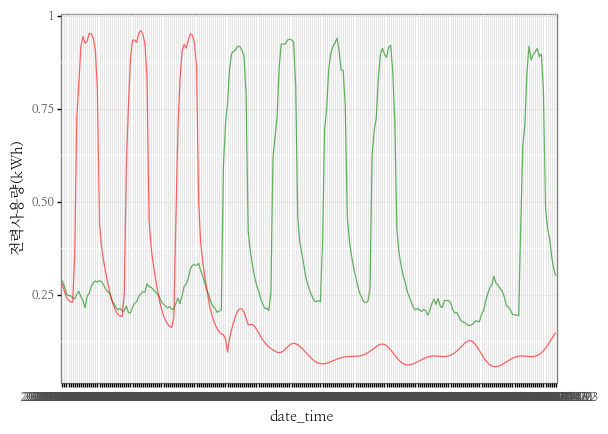

<ggplot: (124049826000)>

In [70]:
predict_grp_idx(grp_val, mae_max, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_83_0.png)

#### **네번째 모델 평가**
- 모델의 깊이를 좀 주었더니 모델의 LOSS가 한번 수렴되는 것 같은 지점에서 한번 더 대폭내려가는 것을 확인할 수 있습니다.
    - 모델의 깊이만 늘렸을 뿐인데 22분에서 2시간으로 엄청 오래걸리는 것을 확인할 수 있었습니다(CPU기준)
- 11번 건물에 대해서는 괜찮게 Fitting이 된 것 같지만, 여전히 잘 따라가지 못하는 샘플들도 있습니다. 아무래도 Y값만 가지고는 모델링이 조금 부족하지 않나라는 생각이 듭니다.

---

### **다섯번째 모델**
- LOSS FUNCTION : MSE
- EPOCH : 100
- LSTM LAYER : 6
- LSTM UNIT : 64
- 데이터 추가

In [80]:
tf_train = pd.concat([
    train["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.fit_transform(train[["num"]]).toarray()).add_prefix("num"), 
    train[["기온(°C)", "풍속(m/s)", "습도(%)", "강수량(mm)", "일조(hr)"]].reset_index(drop = True),
    train[[y_col]].reset_index(drop = True)], 
    axis = 1)

In [81]:
tf_val = pd.concat([
    val["num"].reset_index(drop = True),
    pd.DataFrame(oh_encoder.transform(val[["num"]]).toarray()).add_prefix("num"), 
    val[["기온(°C)", "풍속(m/s)", "습도(%)", "강수량(mm)", "일조(hr)"]].interpolate().reset_index(drop = True),
    val[y_col].reset_index(drop = True)], 
    axis = 1)

In [82]:
minmax_value = tf_train.groupby("num").agg({y_col : [max, min]}).reset_index().droplevel(axis = 1, level = 0)
minmax_value.columns = ["num", "max", "min"]

In [83]:
tf_train[y_col] = tf_train.groupby("num").apply(lambda x : (x[y_col]-min(x[y_col]))/(max(x[y_col])-min(x[y_col]))).values

In [84]:
tf_val = fit_minmmax_scaler(tf_val, minmax_value)

In [85]:
trainX, trainY = make_data(data = tf_train, y_col = y_col, length = 24)

60it [00:14,  4.07it/s]


In [86]:
valX, valY = make_data(data = tf_val, y_col = y_col, length = 24)

60it [00:01, 30.88it/s]


In [87]:
print(trainX.shape)
print(trainY.shape)

(106560, 24, 66)
(106560, 1)


In [88]:
print(valX.shape)
print(valY.shape)

(12960, 24, 66)
(12960, 1)


In [89]:
model=Sequential([
    LSTM(lstm_units, return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**2), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**3), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**4), return_sequences=True, recurrent_dropout=dropout),
    LSTM(int(lstm_units / 2**5), return_sequences=False, recurrent_dropout=dropout),
    Dense(1, kernel_initializer=tf.initializers.zeros())
])

In [90]:
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

In [91]:
%%time
history = model.fit(trainX, trainY, validation_data = (valX, valY), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1,
                    callbacks=[early_stop, save_best_only])

Epoch 1/100
833/833 [==============================] - 103s 108ms/step - loss: 0.2498 - mse: 0.0916 - val_loss: 0.2716 - val_mse: 0.1046
Epoch 2/100
833/833 [==============================] - 82s 99ms/step - loss: 0.2354 - mse: 0.0767 - val_loss: 0.2714 - val_mse: 0.1043
Epoch 3/100
833/833 [==============================] - 83s 99ms/step - loss: 0.1544 - mse: 0.0443 - val_loss: 0.1121 - val_mse: 0.0334
Epoch 4/100
833/833 [==============================] - 84s 100ms/step - loss: 0.0853 - mse: 0.0207 - val_loss: 0.1032 - val_mse: 0.0294
Epoch 5/100
833/833 [==============================] - 83s 99ms/step - loss: 0.0805 - mse: 0.0201 - val_loss: 0.0962 - val_mse: 0.0302
Epoch 6/100
833/833 [==============================] - 83s 99ms/step - loss: 0.0781 - mse: 0.0198 - val_loss: 0.0991 - val_mse: 0.0312
Epoch 7/100
833/833 [==============================] - 83s 100ms/step - loss: 0.0773 - mse: 0.0196 - val_loss: 0.0994 - val_mse: 0.0295
Epoch 8/100
833/833 [==============================

In [92]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 64)            33536     
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 32)            12416     
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 16)            3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 24, 8)             800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 24, 4)             208       
_________________________________________________________________
lstm_14 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

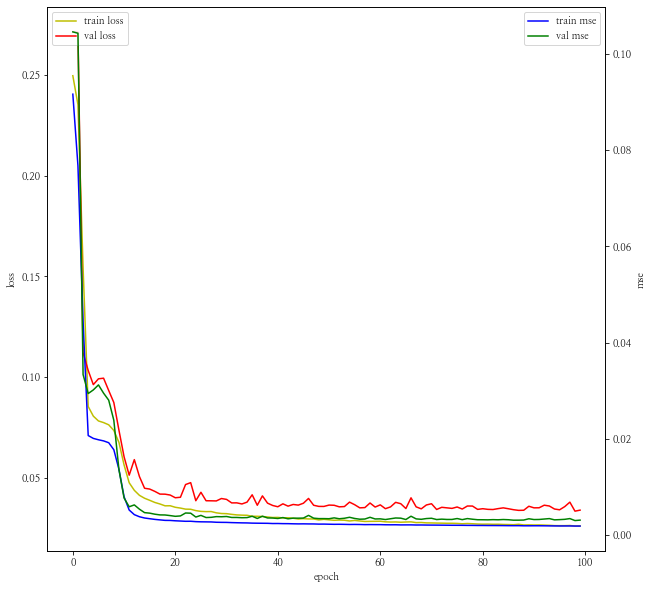

In [93]:
history_plot(history)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_99_0.png)

In [94]:
%time result = return_predict(tf_train, tf_val, val, 24)

100%|███████████████████████████████████████████████████| 60/60 [10:14<00:00, 10.24s/it]

Wall time: 10min 14s


In [95]:
grp_val = pd.concat([result, tf_val[y_col]], axis = 1)

0.1604490547287942


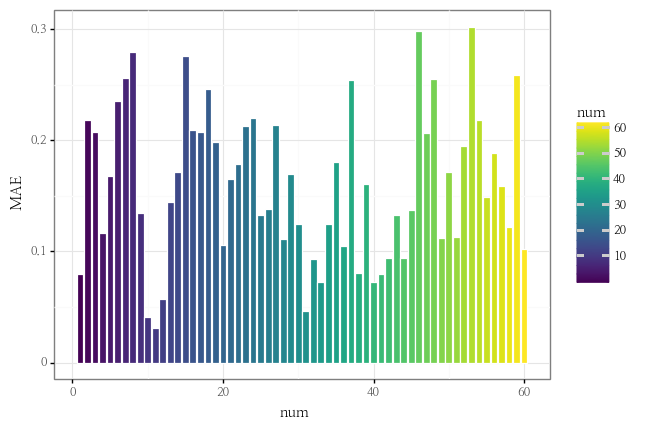

<ggplot: (124080463080)>

In [96]:
print(mean_absolute_error(grp_val.predict, grp_val[y_col]))
metric_plot(grp_val)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_102_1.png)

In [97]:
mae_min = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmin()
mae_max = grp_val.groupby("num").apply(lambda x : mean_absolute_error(x["predict"], x[y_col])).idxmax()
print(f"mae가 가장 낮은 건물은 {mae_min}번 건물이고 mae가 가장 높은 건물은 {mae_max}번 건물입니다.")

mae가 가장 낮은 건물은 11번 건물이고 mae가 가장 높은 건물은 53번 건물입니다.


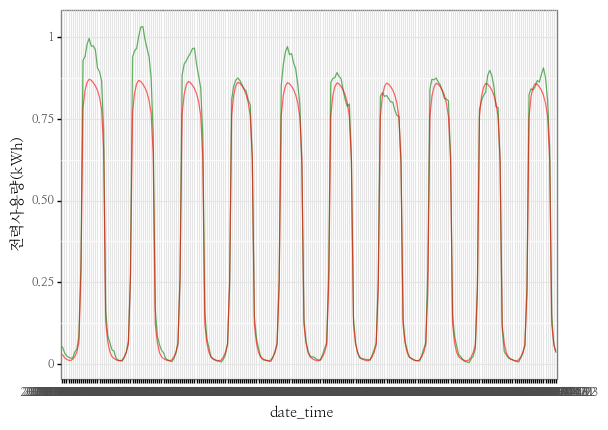

<ggplot: (124100989085)>

In [98]:
predict_grp_idx(grp_val, mae_min, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_104_0.png)

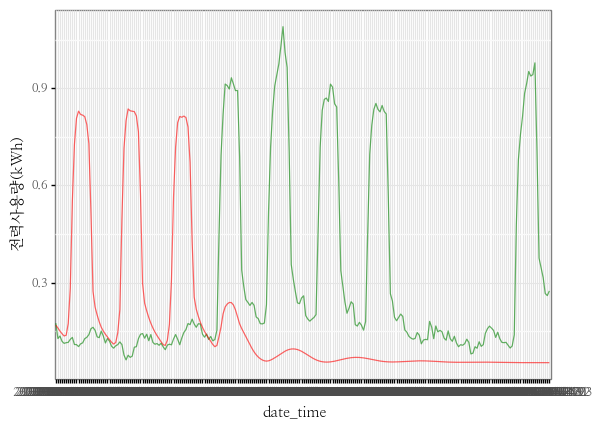

<ggplot: (124081794036)>

In [99]:
predict_grp_idx(grp_val, mae_max, y_col)

![Oops](../assets/img/2021-06-15-TimeSeries2/2021-06-15-TimeSeries2_105_0.png)

#### **다섯번째 모델 평가**
- 모델 LOSS로 봤을 때는 충분히 잘 Fitting된 것으로 보이나 여전히 건물에 따라서 정확도를 가지지 않은 경우들이 있는데, 패턴이 일정하지 않으면 확실히 잘 못 잡아내는 것으로 보입니다.
- 데이터 차원을 조금 늘렸음에도 불구하고 시간은 10분 정도 밖에 차이가 나지 않습니다. 모델의 깊이가 속도에 좀 더 영향을 주는 것 같습니다.

---

결론 : 
- 시계열 데이터들은 패턴들을 따라가기 때문에 이상 패턴에 대해서 잘 적용되지 않을수도 있다는 생각이 들었고, 꼭 LSTM이 ARIMA보다 무조건 좋을 것 같다는 생각은 안 듭니다.
- LOSS FUNCTION을 mae, mse 두가지로 사용해보았는데, 이 것에 대해서도 정리를 해서 올리도록 하겠습니다.

---

code : https://github.com/Chanjun-kim/Chanjun-kim.github.io/blob/main/_ipynb/2021-06-15-TimeSeries2.ipynb

---

참고 자료 : 
- https://dacon.io/competitions/official/235736/codeshare/2628?page=1&dtype=recent
- https://byeongkijeong.github.io/ARIMA-with-Python/
- https://otexts.com/fppkr/arima-estimation.html